# CNN Model

- input = image

- output = score (Mean Vol After Open / Mean Vol Before Open) 

### 0. Installation (torch & fastai)

In [ ]:
# pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# pip install fastai

In [ ]:
# pip install --upgrade pip

In [ ]:
#pip show fastai

In [1]:
import torch
from fastai.vision.all import *
from fastai.metrics import error_rate

In [2]:
torch.cuda.empty_cache()

In [3]:
# print(torch.version.cuda)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(0)

In [6]:
torch.cuda.get_device_name()

'GeForce 940MX'

### 1. Data Prep

In [36]:
data = (ImageDataLoaders.from_csv('../data/imgs', 'image_label_dir.csv', valid_pct=0.2, seed=10, size=224, bs = 5, num_workers = 0))
#         .random_split_by_pct(valid_pct=0.2, seed=10))
#         .split_by_idxs(list(range(400)), list(range(400,496))))
#                  .label_from_df()
#                  .databunch())

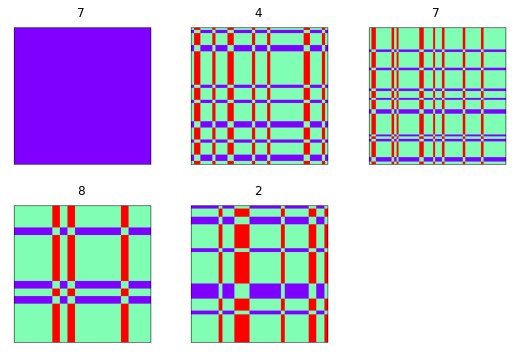

In [37]:
data.show_batch()

### 2. cnn model

In [39]:
learner = cnn_learner(data, models.resnet34, loss_func=mae, metrics=error_rate).to_fp16()
learner.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

### Tuning Model

In [40]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time


AssertionError: ==:
50
5

In [ ]:
### Finding learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
mingradlr = learner.recorder.min_grad_lr